In [43]:
%reload_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt 
import numpy as np
import pandas as pd
from pathlib import Path
import os
from scipy import stats
import seaborn as sns
from statannotations.Annotator import Annotator
import warnings
warnings.filterwarnings('ignore')

# import config variables
from src.config import dir_prep, dir_plots_group_cmpr, cfg_colors
from src.utl import remove_outliers_df, get_log_ax, convert_pvalue_to_asterisks


In [44]:
# find all relevant files
f_list = os.listdir(dir_prep)
str_match = ".csv"
fnms = [s for s in f_list if str_match in s]

In [45]:
# load data and merge pupil and fsr data
dat_pupil = pd.read_csv(Path.joinpath(dir_prep,"all_trials_pupil.csv"), index_col=False)
dat_fsr = pd.read_csv(Path.joinpath(dir_prep,"all_trials_fsr.csv"), index_col=False)

full = pd.merge(dat_fsr, dat_pupil, on=["ID","Trial n","Group","Feedback type","Feedback angle"])

In [46]:
# clean out bad epochs from pupil data
tt_pupil = full.copy()
cfg_out_ppl_per = 30

tt_pupil = tt_pupil.loc[tt_pupil["Percentage bad pupil samples"] < cfg_out_ppl_per,:]

### evaluate differences epr participant for each condition interaction

In [47]:
cfg_out_ppl_per = 25
diff_data = full.copy()

diff_data = diff_data.loc[diff_data["Percentage bad pupil samples"] < cfg_out_ppl_per,:]
diff_data = diff_data[['ID','Group', 'Feedback type', 'Feedback angle','Power [4-12]','Pupil size']]

In [48]:
diffs = diff_data.pivot_table(index=['ID','Group','Feedback type'],columns='Feedback angle',values=['Power [4-12]','Pupil size'],margins=False,aggfunc='mean').reset_index()
diffs['dPower'] = diffs['Power [4-12]']['high']-diffs['Power [4-12]']['low']
diffs['dPpl'] = diffs['Pupil size']['high']-diffs['Pupil size']['low']
diffs = remove_outliers_df(diffs,['dPower'],1)
diffs['dPower'] = abs(diffs['dPower'])

Working on column: dPower


In [49]:
df_vo = len(diffs['Feedback type'] == 'vo')
df_va = len(diffs['Feedback type'] == 'va')
df_ao = len(diffs['Feedback type'] == 'ao')

t_pow_vo, p_pow_vo = stats.mannwhitneyu(diffs['dPower'][np.logical_and(diffs['Feedback type'] == 'vo', diffs['Group'] == 'p')],diffs['dPower'][np.logical_and(diffs['Feedback type'] == 'vo', diffs['Group'] == 'c')])
print(f'Differences for group deltas in visual only for tremor is t[{df_vo}]={t_pow_vo:.2f}, p:{p_pow_vo:.3f}')
t_pow_av, p_pow_av = stats.mannwhitneyu(diffs['dPower'][np.logical_and(diffs['Feedback type'] == 'va', diffs['Group'] == 'p')],diffs['dPower'][np.logical_and(diffs['Feedback type'] == 'va', diffs['Group'] == 'c')])
print(f'Differences for group deltas in auditiv-visual for tremor is t[{df_va}]={t_pow_av:.2f}, p:{p_pow_av:.3f}')
t_pow_ao, p_pow_ao = stats.mannwhitneyu(diffs['dPower'][np.logical_and(diffs['Feedback type'] == 'ao', diffs['Group'] == 'p')],diffs['dPower'][np.logical_and(diffs['Feedback type'] == 'ao', diffs['Group'] == 'c')])
print(f'Differences for group deltas in auditiv only for tremor is t[{df_ao}]={t_pow_ao:.2f}, p:{p_pow_ao:.3f}')



Differences for group deltas in visual only for tremor is t[52]=38.00, p:0.103
Differences for group deltas in auditiv-visual for tremor is t[52]=56.00, p:0.056
Differences for group deltas in auditiv only for tremor is t[52]=39.00, p:0.163


In [50]:
t_ppl_vo, p_ppl_vo = stats.mannwhitneyu(diffs['dPpl'][np.logical_and(diffs['Feedback type'] == 'vo', diffs['Group'] == 'p')],diffs['dPower'][np.logical_and(diffs['Feedback type'] == 'vo', diffs['Group'] == 'c')])
print(f'Differences for group deltas in visual only for pupil size is t[{df_vo}]={t_ppl_vo:.2f}, p:{p_ppl_vo:.3f}')
t_ppl_av, p_ppl_av = stats.mannwhitneyu(diffs['dPpl'][np.logical_and(diffs['Feedback type'] == 'va', diffs['Group'] == 'p')],diffs['dPower'][np.logical_and(diffs['Feedback type'] == 'va', diffs['Group'] == 'c')])
print(f'Differences for group deltas in auditiv-visual for pupil size is t[{df_va}]={t_ppl_av:.2f}, p:{p_ppl_av:.3f}')
t_ppl_ao, p_ppl_ao = stats.mannwhitneyu(diffs['dPpl'][np.logical_and(diffs['Feedback type'] == 'ao', diffs['Group'] == 'p')],diffs['dPower'][np.logical_and(diffs['Feedback type'] == 'ao', diffs['Group'] == 'c')])
print(f'Differences for group deltas in auditiv only for pupil size is t[{df_ao}]={t_ppl_ao:.2f}, p:{p_ppl_ao:.3f}')


Differences for group deltas in visual only for pupil size is t[52]=20.00, p:0.684
Differences for group deltas in auditiv-visual for pupil size is t[52]=nan, p:nan
Differences for group deltas in auditiv only for pupil size is t[52]=24.00, p:0.871


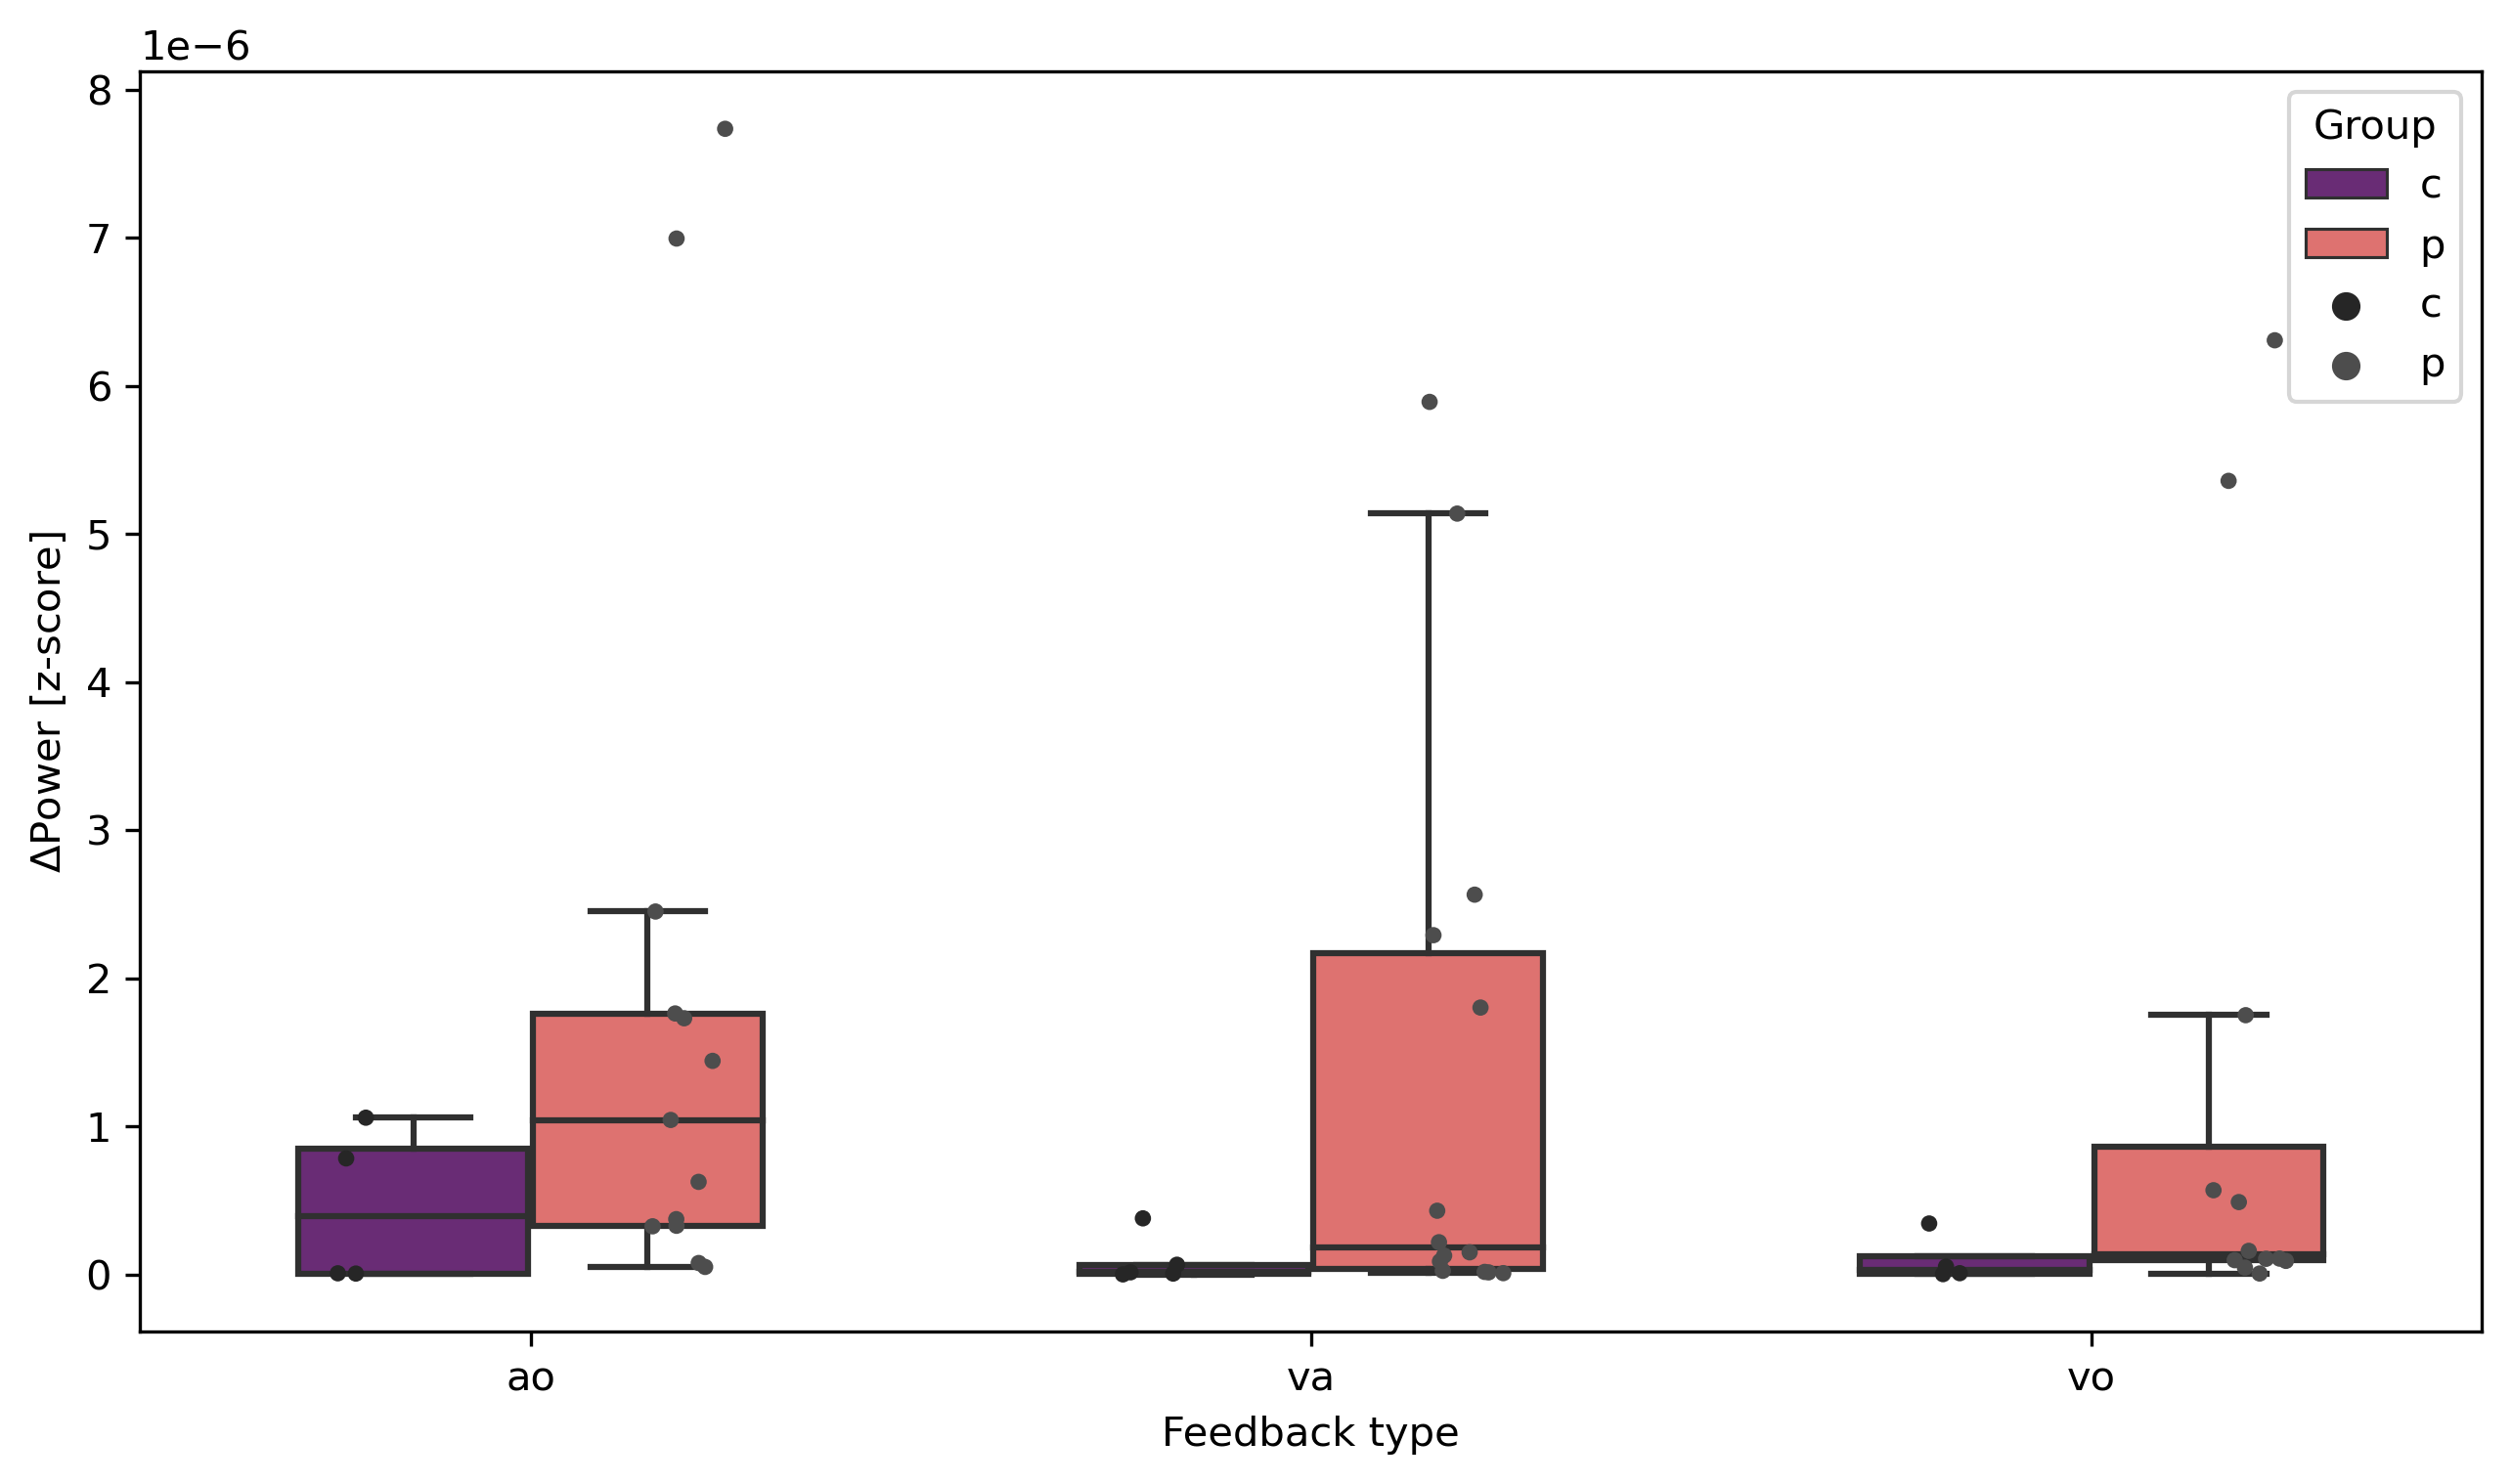

In [51]:
fig, axs = plt.subplots(1, 1, figsize=(8.5, 5), dpi = 300)
sns.boxplot(data = diffs, x = 'Feedback type', y = 'dPower', hue='Group', width=.6,palette=cfg_colors["group_colors"],fliersize=0)
sns.stripplot(data = diffs, x = 'Feedback type', y = 'dPower', hue='Group',size=4, color=".3", linewidth=0,dodge=True)
axs.set_ylabel(r"$\Delta$Power [z-score]")
fig.tight_layout(pad=0.5, w_pad=0.5, h_pad=0.5)
fig.savefig(Path.joinpath(dir_plots_group_cmpr, f"group_cmpr_dpower.png"))

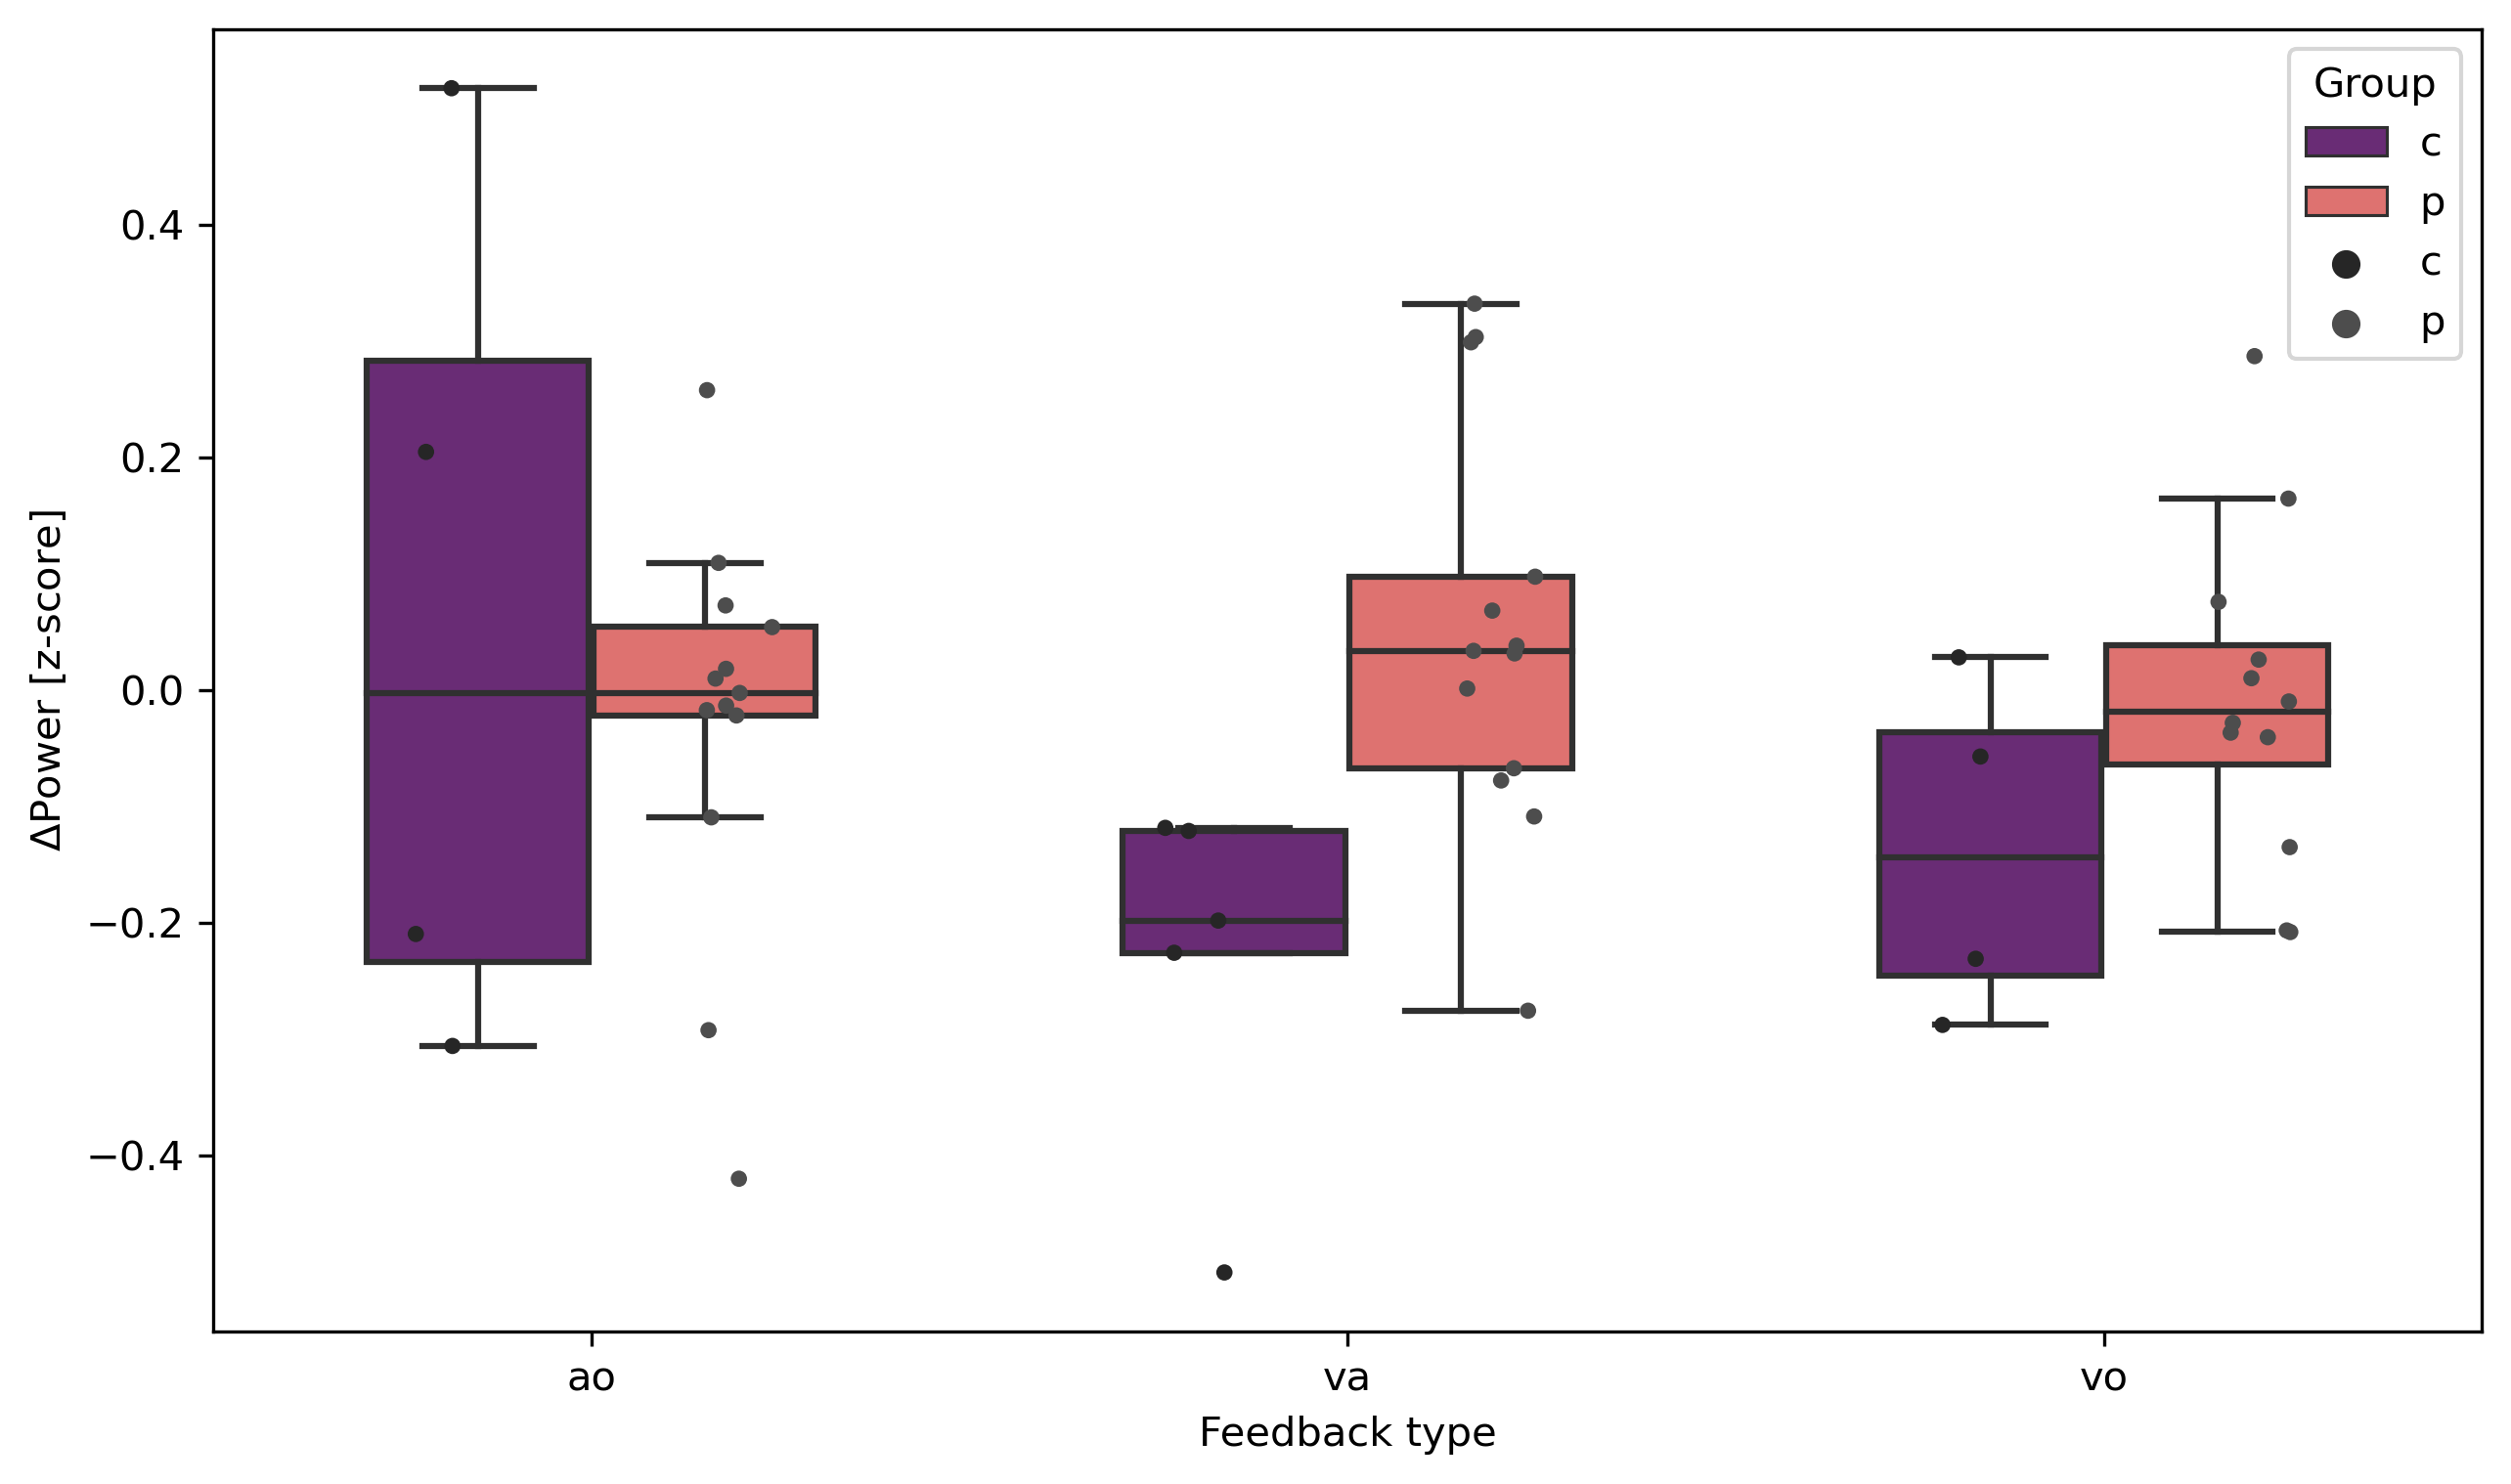

In [52]:
fig, axs = plt.subplots(1, 1, figsize=(8.5, 5), dpi = 300)
sns.boxplot(data = diffs, x = 'Feedback type', y = 'dPpl', hue='Group', width=.6,palette=cfg_colors["group_colors"],fliersize=0)
sns.stripplot(data = diffs, x = 'Feedback type', y = 'dPpl', hue='Group',size=4, color=".3", linewidth=0,dodge=True)
axs.set_ylabel(r"$\Delta$Power [z-score]")
fig.tight_layout(pad=0.5, w_pad=0.5, h_pad=0.5)
fig.savefig(Path.joinpath(dir_plots_group_cmpr, f"group_cmpr_dppl.png"))

## Plot high vs. low per group

In [53]:
full.head(5)

,ID,Trial n,Feedback type,Feedback angle,Power [4-12],Power [1-3],Group,Pupil size,Percentage bad pupil samples
0,c301,0,vo,low,1.540146e-07,0.000076,c,-0.070480,4.272727
1,c301,1,vo,low,1.912623e-07,0.000081,c,-0.188177,4.318182
2,c301,2,vo,high,5.067292e-07,0.000076,c,-0.412544,4.090909
3,c301,3,vo,high,5.259912e-07,0.000095,c,-0.308365,5.818182
4,c301,4,va,low,3.472883e-07,0.000080,c,-0.135686,36.136364


In [54]:
patients = full[full["Group"] == "p"]
controlls = full[full["Group"] == "c"]

patients = remove_outliers_df(patients,["Power [4-12]"],1)
controlls = remove_outliers_df(controlls,["Power [4-12]"],1)

Working on column: Power [4-12]
Working on column: Power [4-12]


p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

va_low vs. va_high: *
vo_low vs. vo_high: **
ao_low vs. ao_high: *


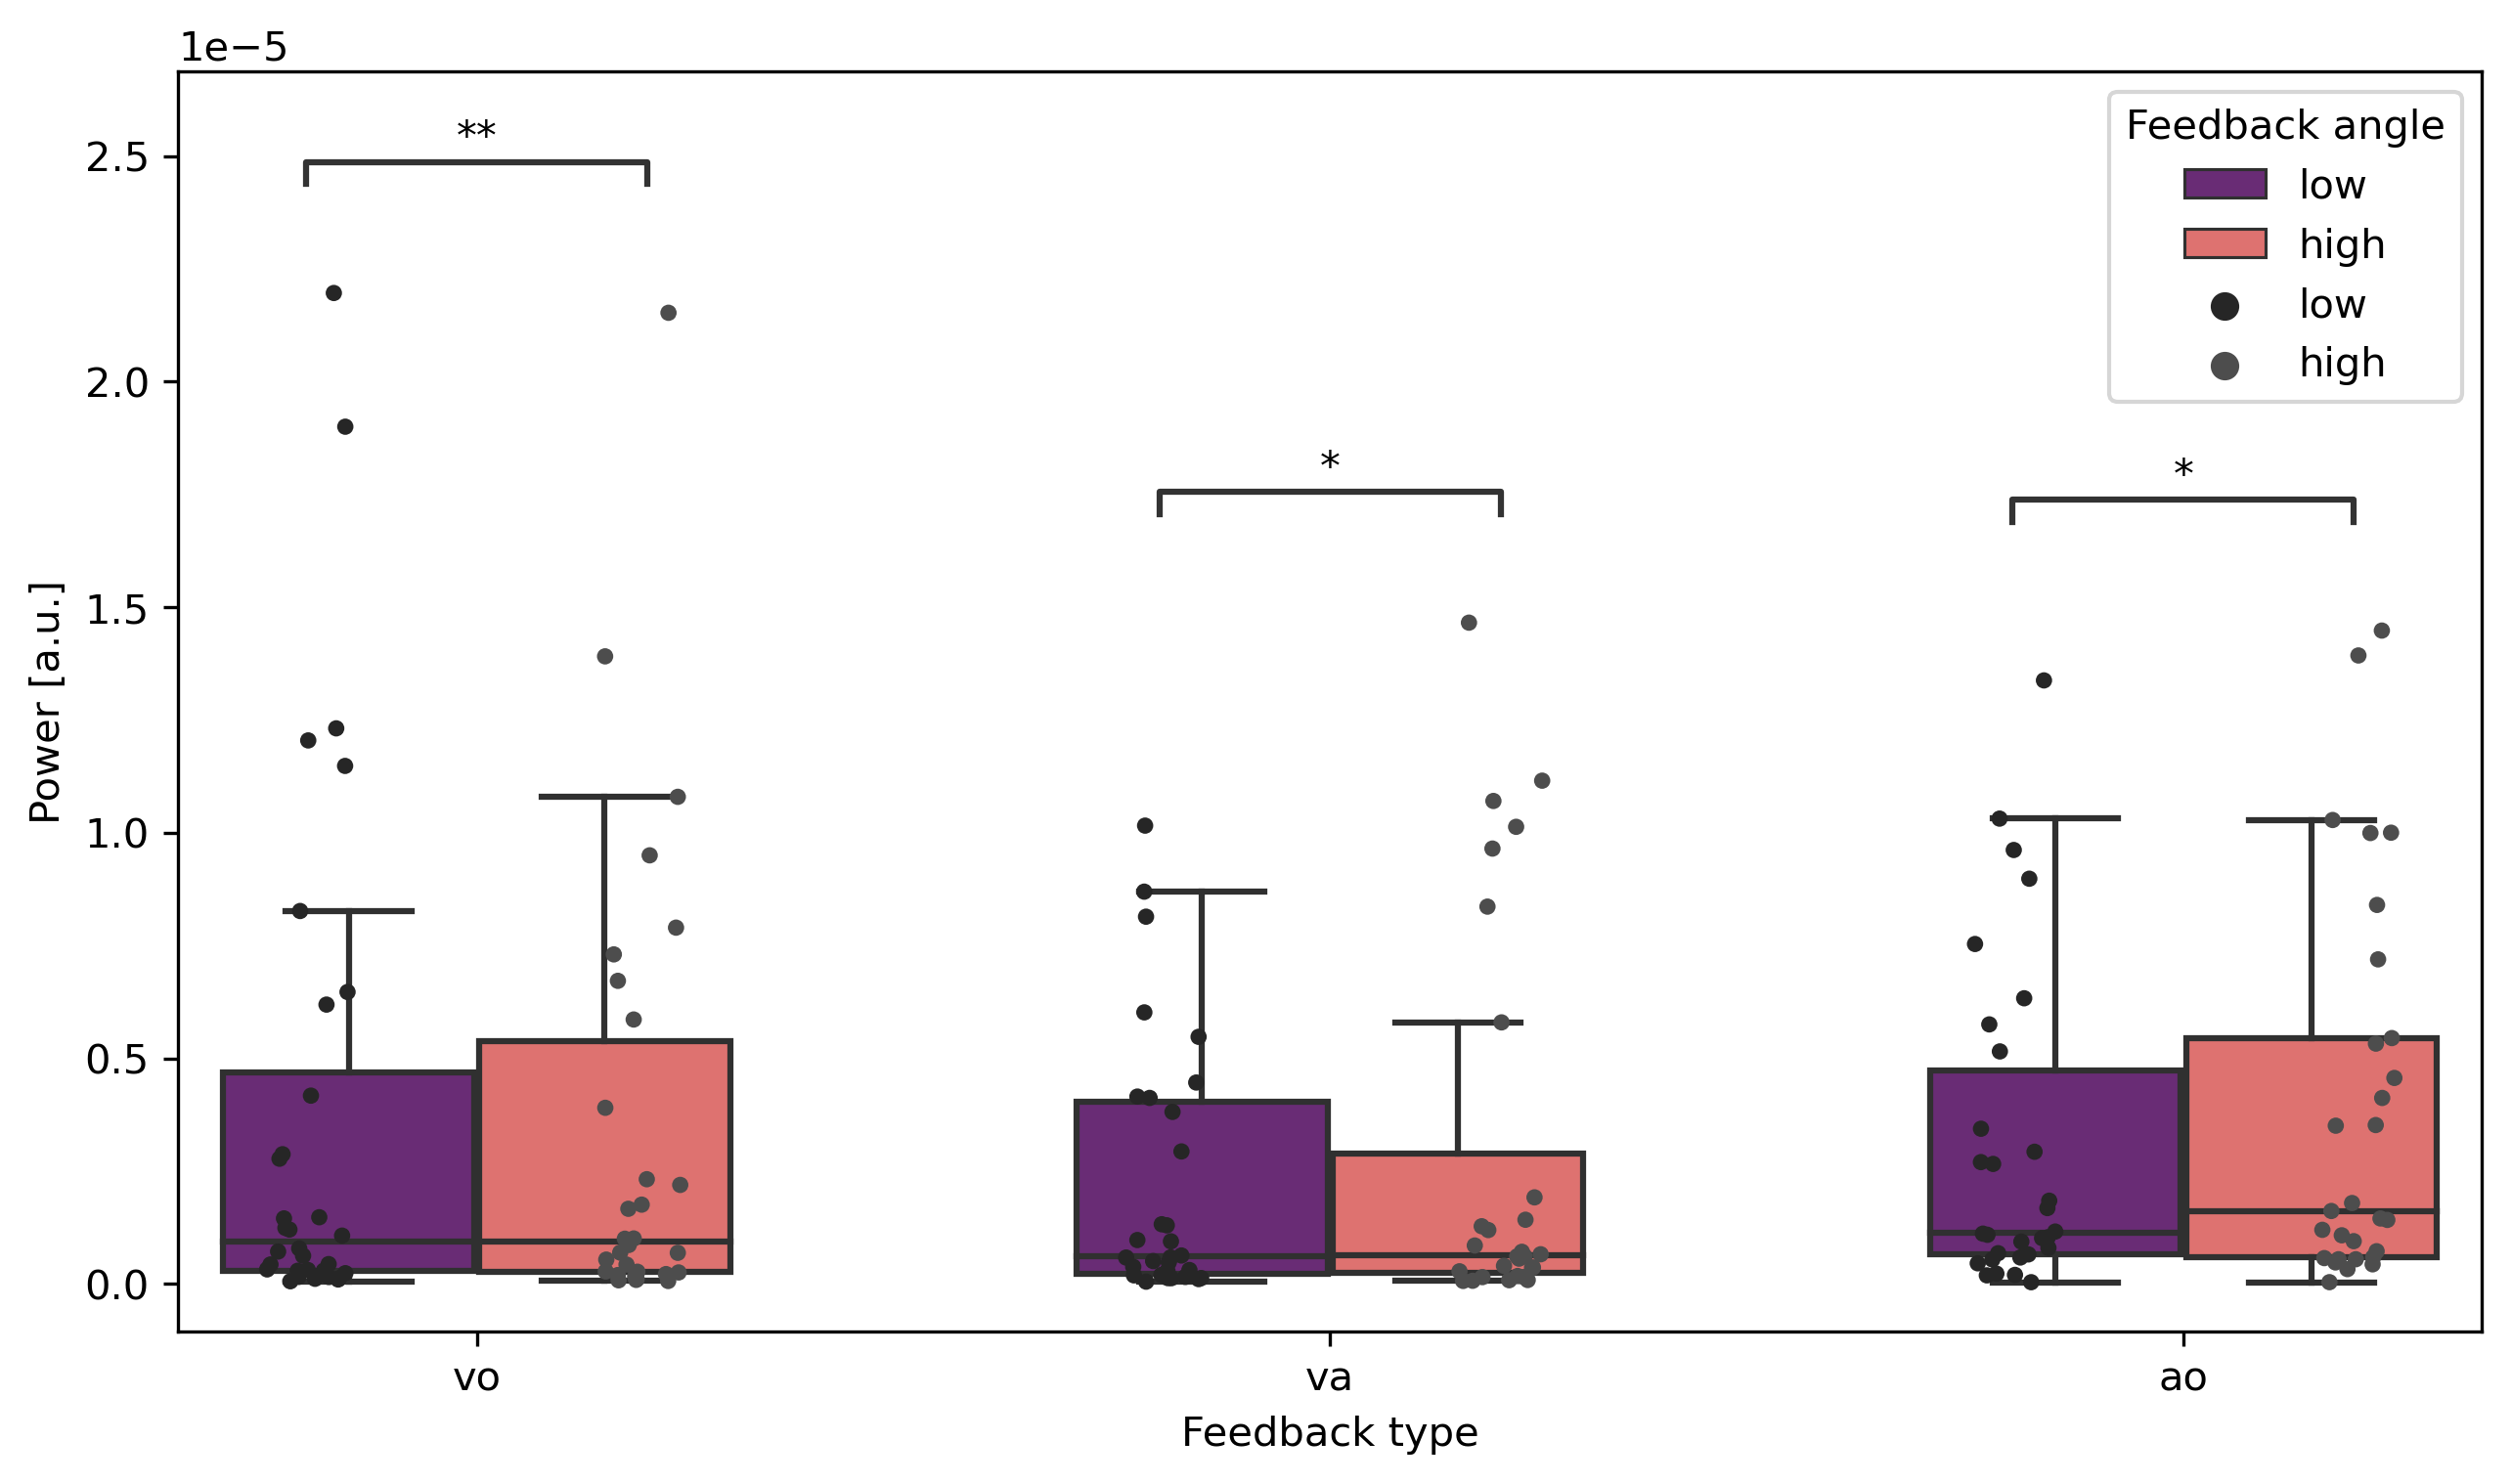

In [57]:
hue_plot_params = {
    'data' : patients,
    'x' : 'Feedback type',
    'y' : 'Power [4-12]',
    'hue' : 'Feedback angle',
    'hue_order' : ['low','high'],
    'order' : ['vo','va','ao'],
}
#fig, axs = plt.subplots(1, 1, figsize=(8.5, 5), dpi = 300)
#sns.boxplot(data = patients, x = x, y = y, order=order, hue=hue, hue_order=hue_order, width=.6, fliersize=0,)
#sns.stripplot(data = patients, x = x, y = y, order=order, hue=hue, hue_order = hue_order, size=4, color=".3", linewidth=0,dodge=True)

pairs=[
    (("vo", "low"), ("vo", "high")),
    (("va", "low"), ("va", "high")),
    (("ao", "low"), ("ao", "high")),
]

pvalues = [0.0018, 0.041, 0.013]

# Transform each p-value to "p=" in scientific notation
start_pvalues = [convert_pvalue_to_asterisks(pvalue) for pvalue in pvalues]

# formatted_pvalues
# ['p=1.35e-04', 'p=2.56e-01', 'p=2.30e-04']

fig, axs = plt.subplots(1, 1, figsize=(8.5, 5), dpi = 300)

# Plot with seaborn
axs = sns.boxplot(ax=axs, width=.6, palette = cfg_colors["group_colors"], fliersize=0, **hue_plot_params)
axs = sns.stripplot(ax=axs,**hue_plot_params, size=4, color=".3", linewidth=0,dodge=True)

# Add annotations
annotator = Annotator(axs, pairs, **hue_plot_params)
annotator.set_custom_annotations(start_pvalues)
annotator.annotate(line_offset_to_group=0.1)

axs.set_ylabel(r"Power [a.u.]")
fig.tight_layout(pad=0.5, w_pad=0.5, h_pad=0.5)

In [56]:
c[0]

NameError: name 'c' is not defined

In [ ]:
# Check for statistical significance
significant_combinations = []
combinations = pairs
for c in combinations:
    data1 = patients[np.where(c[0]]
    data2 = patients[c[1] - 1]
    # Significance
    U, p = stats.mannwhitneyu(data1, data2, alternative='two-sided')
    if p < 0.05:
        significant_combinations.append([c, p])

TypeError: unsupported operand type(s) for -: 'tuple' and 'int'